In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from os import listdir
from os.path import isfile, join, isdir
import matplotlib
import sys
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import create_protein_graph_structure_jake as jk
from scipy.spatial import distance_matrix
from Bio.SVDSuperimposer import SVDSuperimposer
import os
sup = SVDSuperimposer()


mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["axes.formatter.use_mathtext"]=True

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size' : 10})
rc('text', usetex=False)
font_size = 16

In [2]:
## calculate individual and total rmsd/irmsd of complex/monomers
## requires precalculated rsasa data from standalone_freesasa_rsasa_code.py of monomers and complex
## in order to define interface
## assumes pdbnaming convention of <image_number>_<pdbid>_<chainid>.pdb
## target: PDBid of given complex, chain1/chain2: chainid, img: image number
def calc_rmsd_irmsd(target,chain1,chain2,img):
    
    main_dir=Path('/gpfs/gibbs/pi/ohern/nb685/Interpolation/Supersampling/Targets/rSASA/')
    
    complex_rsasa_df=pd.read_csv(f'/gpfs/gibbs/pi/ohern/nb685/Interpolation/Supersampling/Targets/rSASA/{target}/{target}_cleaned_H_sasa_data.csv',index_col=0)
    chain1_rsasa_df=pd.read_csv(f'/gpfs/gibbs/pi/ohern/nb685/Interpolation/Supersampling/Targets/rSASA/{target}/{target}_cleaned_H_{chain1}_sasa_data.csv',index_col=0)
    chain2_rsasa_df=pd.read_csv(f'/gpfs/gibbs/pi/ohern/nb685/Interpolation/Supersampling/Targets/rSASA/{target}/{target}_cleaned_H_{chain2}_sasa_data.csv',index_col=0)

    monomer_rsasa_df=pd.concat((chain1_rsasa_df,chain2_rsasa_df))

    ## Find all amino acids with deltarSASA>0, these are interface residues
    complex_rsasa_df['delta_rSASA']=monomer_rsasa_df['rSASA'].values-complex_rsasa_df['rSASA'].values

    complex_rsasa_df['interface_bool']=[0 if i==0 else 1 for i in complex_rsasa_df['delta_rSASA'].values]
 
    complex_df=jk.get_protein_information(f'{target}_cleaned_H.pdb',main_dir / Path(f'{target}'))
    complex_df_ca=complex_df[complex_df['ca_bool']==1].copy()
    complex_df_ca['interface_bool']=complex_rsasa_df['interface_bool'].values

    
    bound1_df_ca=complex_df_ca[complex_df_ca['chain_name']==chain1].set_index('aa_ind')
    bound2_df_ca=complex_df_ca[complex_df_ca['chain_name']==chain2].set_index('aa_ind')

    img1_df=jk.get_protein_information(f'{str(img)}_{target}_{chain1}.pdb',main_dir / Path(f'{target}'))
    img1_df_ca=img1_df[img1_df['ca_bool']==1].set_index('aa_ind')

    img2_df=jk.get_protein_information(f'{str(img)}_{target}_{chain2}.pdb',main_dir / Path(f'{target}'))
    img2_df_ca=img2_df[img2_df['ca_bool']==1].set_index('aa_ind')
    
    ## Special case due to chain naming errors from bm5.5
    if target=='1FLE':
        bound1_df_ca=complex_df_ca[complex_df_ca['chain_name']==chain1].reset_index()
        img1_df_ca=img1_df[img1_df['ca_bool']==1].reset_index()
    
    chain1_total_df=pd.merge(bound1_df_ca, img1_df_ca, left_index=True, right_index=True,suffixes=('_b','_img'))
    chain2_total_df=pd.merge(bound2_df_ca,img2_df_ca,left_index=True,right_index=True,suffixes=('_b','_img'))
    

    ##Calculate RMSD
    bound_coords1=chain1_total_df[['x_coord_b','y_coord_b','z_coord_b']].values
    img_coords1=chain1_total_df[['x_coord_img','y_coord_img','z_coord_img']].values
    bound_coords2=chain2_total_df[['x_coord_b','y_coord_b','z_coord_b']].values
    img_coords2=chain2_total_df[['x_coord_img','y_coord_img','z_coord_img']].values
    
    ##Align coords
    sup.set(bound_coords1, img_coords1)
    sup.run()
    img_align_coords1=sup.get_transformed()
    
    sup.set(bound_coords2, img_coords2)
    sup.run()
    img_align_coords2=sup.get_transformed()
    
    
    diff1=np.sum(np.square(bound_coords1-img_align_coords1))
    diff2=np.sum(np.square(bound_coords2-img_align_coords2))
    
    chain1_rmsd=np.sqrt(1/(len(bound_coords1))*(diff1))
    chain2_rmsd=np.sqrt(1/(len(bound_coords2))*(diff2))
    
    total_rmsd=np.sqrt(1/(len(bound_coords1)+len(bound_coords2))*(diff1+diff2))

    ##Calculate iRMSD
    bound_inter_coords1=chain1_total_df[chain1_total_df['interface_bool']==1][['x_coord_b','y_coord_b','z_coord_b']].values
    img_inter_coords1=chain1_total_df[(chain1_total_df['interface_bool']==1)][['x_coord_img','y_coord_img','z_coord_img']].values
    bound_inter_coords2=chain2_total_df[(chain2_total_df['interface_bool']==1)][['x_coord_b','y_coord_b','z_coord_b']].values
    img_inter_coords2=chain2_total_df[(chain2_total_df['interface_bool']==1)][['x_coord_img','y_coord_img','z_coord_img']].values

    ##Align Coords
    sup.set(bound_inter_coords1, img_inter_coords1)
    sup.run()
    img_inter_align_coords1=sup.get_transformed()

    
    sup.set(bound_inter_coords2, img_inter_coords2)
    sup.run()
    img_inter_align_coords2=sup.get_transformed()
    
 
    diff1=np.sum(np.square(bound_inter_coords1-img_inter_align_coords1))
    diff2=np.sum(np.square(bound_inter_coords2-img_inter_align_coords2))

    chain1_irmsd=np.sqrt(1/(len(bound_inter_coords1))*(diff1))
    chain2_irmsd=np.sqrt(1/(len(bound_inter_coords2))*(diff2))
    total_irmsd=np.sqrt(1/(len(bound_inter_coords1)+len(bound_inter_coords2))*(diff1+diff2))
    
    return [chain1_rmsd,chain2_rmsd,total_rmsd,chain1_irmsd,chain2_irmsd,total_irmsd]


    

In [3]:
## Load scores based on different output conventions
def load_rosetta_dat(score_path, file, file_indicator):
    scores_df=pd.read_csv(score_path/Path(file),skiprows=0,header=1,usecols=['total_score','description'],sep='\s+').dropna()
    scores_df['description']=[i.split(file_indicator)[0] for i in scores_df['description']]
    scores_df.rename({'total_score':'rosetta','description':'decoy'},axis=1,inplace=True)
    scores_df=scores_df.set_index('decoy')
    return scores_df

def load_hdock_dat(score_path,file,file_indicator):
    scores_df=pd.read_csv(score_path/Path(file),names=['decoy','itscorepp'],sep='\s+')
    scores_df['decoy']=[i.split(file_indicator)[0] for i in scores_df['decoy']]
    scores_df=scores_df.set_index('decoy')
    return scores_df

def load_zrank_dat(score_path,file,file_indicator):
    scores_df=pd.read_csv(score_path/Path(file),names=['decoy','zrank'],sep='\s+')
    scores_df['decoy']=[i.split(file_indicator)[0] for i in scores_df['decoy']]
    scores_df=scores_df.set_index('decoy')
    return scores_df

def load_pydock_dat(score_path,file,file_indicator):
    scores_df=pd.read_csv(score_path/Path(file),usecols=[0,5],names=['decoy','pydock'],sep='\s+')
    scores_df['decoy']=[i.split(file_indicator)[0] for i in scores_df['decoy']]
    scores_df=scores_df.set_index('decoy')
    return scores_df

def load_voromqa_dat(score_path,file,file_indicator):
    scores_df=pd.read_csv(score_path/Path(file),usecols=[0,4],names=['decoy','voromqa'],sep='\s+')
    scores_df['decoy']=[i.split(file_indicator)[0] for i in scores_df['decoy']]
    scores_df=scores_df.set_index('decoy')
    return scores_df

def load_deeprank_dat(score_path,file,file_indicator):
    scores_df=pd.read_csv(score_path/Path(file))
    scores_df['pdb_id']=[i.split(file_indicator)[0] for i in scores_df['pdb_id']]
    scores_df.rename({'pdb_id':'decoy','predicted_fnat':'deeprank'},axis=1,inplace=True)
    scores_df=scores_df.set_index('decoy')
    return scores_df


In [4]:
## Load all scores for single target, turn into a dataframe
def get_scores(main_path,target,file_indicator,scoretype,run_num=None):
    targ_path=main_path / Path(f'{target}_scores')
    
    rosetta_fh=f'rosetta_scores_{scoretype}_{target}.txt'
    hdock_fh=f'hdock_scores_{scoretype}_{target}.txt'
    zrank_fh=f'zrank_files_{scoretype}_{target}.txt.zr.out'
    pydock_fh=f'pydock_scores_{scoretype}_{target}.txt'
    voromqa_fh=f'voromqa_scores_{scoretype}_{target}.txt'
    dockq_fh=f'dockQ_{scoretype}_{target}.csv'
    deeprank_fh=f'deeprank_scores_{scoretype}_{target}.csv'
    
    if run_num!=None:
        dockq_fh=f'dockQ_{scoretype}_{str(run_num)}_{target[:4]}.csv'
 
    target_df=pd.read_csv(targ_path / Path(dockq_fh))
    target_df['model']=[i.split('_corrected_H_0001')[0] for i in target_df['model']]
    target_df.rename({'model':'decoy'},axis=1,inplace=True)
    target_df=target_df.set_index('decoy')
    
    rosetta_df=load_rosetta_dat(targ_path,rosetta_fh,file_indicator)
    hdock_df=load_hdock_dat(targ_path,hdock_fh,file_indicator)
    zrank_df=load_zrank_dat(targ_path,zrank_fh,file_indicator)
    pydock_df=load_pydock_dat(targ_path,pydock_fh,file_indicator)
    voromqa_df=load_voromqa_dat(targ_path,voromqa_fh,file_indicator)
    deeprank_df=load_deeprank_dat(targ_path,deeprank_fh,file_indicator)
    
    target_df=target_df.join((rosetta_df['rosetta'],hdock_df['itscorepp'],zrank_df['zrank'],pydock_df['pydock'],voromqa_df['voromqa'],deeprank_df['deeprank']))
    
    return target_df



In [5]:
##Load all the uniformly sampled score data for all targets and images

main_dir=Path('/gpfs/gibbs/pi/ohern/nb685/Interpolation/Supersampling/Scores/')
bm55_sampled_df=pd.read_csv(Path('/gpfs/gibbs/pi/ohern/nb685/Interpolation/sampled_inter_targets.csv'))

bm55_sampled_df=bm55_sampled_df.sort_values(by='I-RMSD').reset_index()

runs=[200,400,600,800,1000]

finished_targs=[]
rmsd_dict={}
run_dict={}
ss_dict={}
for i in bm55_sampled_df.index:
    
    
    row=bm55_sampled_df.iloc[i]
    targ=row['Complex']

    chain1=row['Chains'].split(':')[0]
    chain2=row['Chains'].split(':')[1]

    ss_dat=pd.read_csv(f'/gpfs/gibbs/pi/ohern/nb685/Decoys/Balanced_Dataset/all_supersampled_balanced_csv/{targ.lower()}_supersampled_balanced_scores.csv',index_col=0)
    ss_dict[targ]=ss_dat
    for j in runs:


        rmsds=calc_rmsd_irmsd(targ,chain1,chain2,j)

        targ_img=f'{targ}_{str(j)}'
        sampled_df=get_scores(main_dir/Path(targ),targ_img,'_corrected_H_0001','sampled')
        random_df=get_scores(main_dir/Path(targ),targ_img,'_corrected_H_0001','random')

        sampled_neg=len(sampled_df[sampled_df['dockQ']<0.23])
        sampled_pos=len(sampled_df[sampled_df['dockQ']>0.23])


        targ_df=pd.concat((sampled_df,random_df[0:sampled_pos-sampled_neg]))
        run_dict[f'{targ}_{str(j)}']=targ_df
        rmsd_dict[f'{targ}_{str(j)}']=rmsds
    finished_targs.append(targ)

rmsd_df=pd.DataFrame.from_dict(rmsd_dict,orient='index', columns=['Chain1_RMSD','Chain2_RMSD','Total_RMSD','Chain1_iRMSD','Chain2_iRMSD','Total_iRMSD'])

finished_targs
final_rmsd=[]

for targ in finished_targs:
    final_rmsd.append([targ,rmsd_dict[f'{targ}_1000'][5]])
    
final_irmsd_df=pd.DataFrame(final_rmsd).sort_values(1)

In [6]:
## Calculate spearman correlation per target per scoring function 
## find average/standard deviation across scoring function
## for RMSD>0 (monomers not in bound conformation)
## RMSD=0 calculated later
score_list=['ZRank2','Rosetta','ITScorePP','VoroMQA','PyDock']
rho_run_dict={}
rho_avg_dict={}
run_targs=[]

for i in run_dict.keys():
    targ=i
    
    rosetta_rho=spearmanr(run_dict[f'{targ}']['dockQ'],run_dict[f'{targ}']['rosetta'],nan_policy='omit')[0]
    itscorepp_rho=spearmanr(run_dict[f'{targ}']['dockQ'],run_dict[f'{targ}']['itscorepp'],nan_policy='omit')[0]
    zrank_rho=spearmanr(run_dict[f'{targ}']['dockQ'],run_dict[f'{targ}']['zrank'])[0]
    pydock_rho=spearmanr(run_dict[f'{targ}']['dockQ'],run_dict[f'{targ}']['pydock'])[0]
    voromqa_rho=-spearmanr(run_dict[f'{targ}']['dockQ'],run_dict[f'{targ}']['voromqa'])[0]

    all_rho=[zrank_rho,rosetta_rho,itscorepp_rho,voromqa_rho,pydock_rho]
    rho_avg=np.mean(all_rho)
    rho_std=np.std(all_rho)
    
    if ~np.isnan(rho_avg):

        rho_dict={key:val for key,val in zip(score_list,all_rho)}
        rho_run_dict[f'{targ}']=rho_dict
        rho_avg_dict[f'{targ}']=[rho_avg,rho_std]

rho_run_dict.keys()

dict_keys(['1UGH_200', '1UGH_400', '1UGH_600', '1UGH_800', '1UGH_1000', '1FLE_200', '1FLE_400', '1FLE_600', '1FLE_800', '1FLE_1000', '2A5T_200', '2A5T_400', '2A5T_600', '2A5T_800', '2A5T_1000', '2OZA_200', '2OZA_400', '2OZA_600', '2OZA_800', '2OZA_1000', '2HRK_200', '2HRK_400', '2HRK_600', '2HRK_800', '2HRK_1000', '2Z0E_200', '2Z0E_400', '2Z0E_600', '2Z0E_800', '2Z0E_1000', '1ACB_200', '1ACB_400', '1ACB_600', '1ACB_800', '1ACB_1000', '1ZLI_200', '1ZLI_400', '1ZLI_600', '1ZLI_800', '1ZLI_1000', '2C0L_200', '2C0L_400', '2C0L_600', '2C0L_800', '2C0L_1000', '1BKD_200', '1BKD_400', '1BKD_600', '1BKD_800', '1BKD_1000', '2O3B_200', '2O3B_400', '2O3B_600', '2O3B_800', '2O3B_1000', '1ATN_200', '1ATN_400', '1ATN_600', '1ATN_800', '1ATN_1000', '1FQ1_200', '1FQ1_400', '1FQ1_600', '1FQ1_800', '1FQ1_1000', '1R8S_200', '1R8S_400', '1R8S_600', '1R8S_800', '1R8S_1000', '1Y64_200', '1Y64_400', '1Y64_600', '1Y64_800', '1Y64_1000', '3K9P_200', '3K9P_400', '3K9P_600', '3K9P_800', '3K9P_1000'])

In [12]:
## Calculate spearman correlation per target per scoring function 
## find average/standard deviation across targets for each step in irmsd space

score_rho_avg_df=pd.DataFrame(columns=score_list,index=[0]+runs)
score_rho_std_df=pd.DataFrame(columns=score_list,index=[0]+runs)

ss_rosetta_rho=[]
ss_itscorepp_rho=[]
ss_zrank_rho=[]
ss_pydock_rho=[]
ss_voromqa_rho=[]

for targ in finished_targs:
    ss_rosetta_rho.append(spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['Rosetta'])[0])
                          
    try:
        ss_itscorepp_rho.append(spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['itscorepp'],nan_policy='omit')[0])
    except:
        ss_itscorepp_rho.append(spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['HDOCK'],nan_policy='omit')[0])
                                          
    ss_zrank_rho.append(spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['ZRank'])[0])
    ss_pydock_rho.append(spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['PyDock'])[0])
    ss_voromqa_rho.append(-spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['VoroMQA'])[0])

score_rho_avg_df.loc[0,'Rosetta']=np.mean(ss_rosetta_rho)
score_rho_avg_df.loc[0,'ITScorePP']=np.mean(ss_itscorepp_rho)
score_rho_avg_df.loc[0,'ZRank2']=np.mean(ss_zrank_rho)
score_rho_avg_df.loc[0,'PyDock']=np.mean(ss_pydock_rho)
score_rho_avg_df.loc[0,'VoroMQA']=np.mean(ss_voromqa_rho)

score_rho_std_df.loc[0,'Rosetta']=np.std(ss_rosetta_rho)
score_rho_std_df.loc[0,'ITScorePP']=np.std(ss_itscorepp_rho)
score_rho_std_df.loc[0,'ZRank2']=np.std(ss_zrank_rho)
score_rho_std_df.loc[0,'PyDock']=np.std(ss_pydock_rho)
score_rho_std_df.loc[0,'VoroMQA']=np.std(ss_voromqa_rho)

for i in runs:
    rosetta_rho=[]
    itscorepp_rho=[]
    zrank_rho=[]
    pydock_rho=[]
    voromqa_rho=[]
    deeprank_rho=[]
    
    for j in finished_targs:
        rosetta_rho.append(rho_run_dict[f'{j}_{i}']['Rosetta'])
        itscorepp_rho.append(rho_run_dict[f'{j}_{i}']['ITScorePP'])
        zrank_rho.append(rho_run_dict[f'{j}_{i}']['ZRank2'])
        voromqa_rho.append(rho_run_dict[f'{j}_{i}']['VoroMQA'])
        pydock_rho.append(rho_run_dict[f'{j}_{i}']['PyDock'])
    
    score_rho_avg_df.loc[i,'Rosetta']=np.mean(rosetta_rho)
    score_rho_avg_df.loc[i,'ITScorePP']=np.mean(itscorepp_rho)
    score_rho_avg_df.loc[i,'ZRank2']=np.mean(zrank_rho)
    score_rho_avg_df.loc[i,'PyDock']=np.mean(pydock_rho)
    score_rho_avg_df.loc[i,'VoroMQA']=np.mean(voromqa_rho)
                               
    score_rho_std_df.loc[i,'Rosetta']=np.std(rosetta_rho)
    score_rho_std_df.loc[i,'ITScorePP']=np.std(itscorepp_rho)
    score_rho_std_df.loc[i,'ZRank2']=np.std(zrank_rho)
    score_rho_std_df.loc[i,'PyDock']=np.std(pydock_rho)
    score_rho_std_df.loc[i,'VoroMQA']=np.std(voromqa_rho)

rmsd_df.sort_values(by='Total_iRMSD')

,Chain1_RMSD,Chain2_RMSD,Total_RMSD,Chain1_iRMSD,Chain2_iRMSD,Total_iRMSD
3K9P_200,0.258663,0.128322,0.231205,0.137157,0.136159,0.136614
1UGH_200,0.077854,0.167889,0.109589,0.080059,0.181036,0.140671
3K9P_400,0.517284,0.256490,0.462353,0.274094,0.272008,0.272958
2HRK_200,1.730150,1.130451,1.535342,0.316905,0.236538,0.275985
1FLE_200,0.075633,0.556449,0.236677,0.104961,0.430828,0.279587
...,...,...,...,...,...,...
1FQ1_1000,10.990550,3.433281,7.562290,1.133491,5.172226,3.877763
1R8S_800,3.267251,4.486297,3.986423,4.108533,3.968933,4.033964
2OZA_800,2.411781,6.579967,4.895900,2.418556,6.584924,4.903444
1R8S_1000,4.083823,5.607758,4.982870,5.098376,4.948301,5.018124


In [14]:
## identify which targets have 20% decrease in performance by 1.5A in irmsd

targ_performance=set()
targ_avg_rho_df=pd.DataFrame(columns=runs,index=final_irmsd_df[0])
for ind,targ in enumerate(final_irmsd_df[0]):
    targ_rmsd=[0]

    ss_rosetta_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['Rosetta'])[0]
    try:
        ss_itscorepp_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['itscorepp'],nan_policy='omit')[0]
    except:
        ss_itscorepp_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['HDOCK'],nan_policy='omit')[0]
    ss_zrank_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['ZRank'])[0]
    ss_pydock_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['PyDock'])[0]
    ss_voromqa_rho=-spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['VoroMQA'])[0]
    ss_all_rho=[ss_zrank_rho,ss_rosetta_rho,ss_itscorepp_rho,ss_voromqa_rho,ss_pydock_rho]
    targ_reweight=np.mean(ss_all_rho)
    targ_rho_avg=[np.mean(ss_all_rho)/targ_reweight]

    targ_rho_std=[np.std(ss_all_rho)]

    for i in runs:
        if rmsd_dict[f'{targ}_{i}'][5]<1.5:
            targ_rmsd.append(rmsd_dict[f'{targ}_{i}'][5])
            targ_rho_avg.append(rho_avg_dict[f'{targ}_{i}'][0])
            targ_rho_std.append(rho_avg_dict[f'{targ}_{i}'][1])
            targ_avg_rho_df.loc[targ,i]=rho_avg_dict[f'{targ}_{i}'][0]
            if targ_reweight-rho_avg_dict[f'{targ}_{i}'][0]<=-.2:
                print(f'{targ}_{i}',targ_reweight,rmsd_dict[f'{targ}_{i}'][5],rho_avg_dict[f'{targ}_{i}'][0])
                targ_performance.add(targ)
            
            
targ_performance


3K9P_200 -0.4837331030807198 0.1366136072293812 -0.19549627707187206
3K9P_400 -0.4837331030807198 0.27295781455631635 -0.17095813225049689
3K9P_600 -0.4837331030807198 0.4097032563832891 -0.18768505365183566
3K9P_800 -0.4837331030807198 0.5468389127640338 -0.20449956155156485
3K9P_1000 -0.4837331030807198 0.6847277146076792 -0.26977905126726975
2HRK_800 -0.486179028632111 1.0858181375753113 -0.24793836123203664
2A5T_400 -0.5569574915592852 0.6326930922039777 -0.31842986592212463
2A5T_800 -0.5569574915592852 1.265522517069901 -0.26181895316446624
1ACB_400 -0.6628391708192408 0.9316105291915641 -0.3146684062486698
1ACB_600 -0.6628391708192408 1.3967869536709285 -0.01932362822642674
2O3B_400 -0.6499914723822712 1.186049432711781 -0.4269165772618043
2C0L_400 -0.5986195782488859 1.3026349356868974 -0.04180067587112586
1BKD_400 -0.7998080410174305 1.2286891513325409 -0.4616227807694619
2OZA_200 -0.8184929608012086 1.2258598322451575 -0.5545671228009261


{'1ACB', '1BKD', '2A5T', '2C0L', '2HRK', '2O3B', '2OZA', '3K9P'}

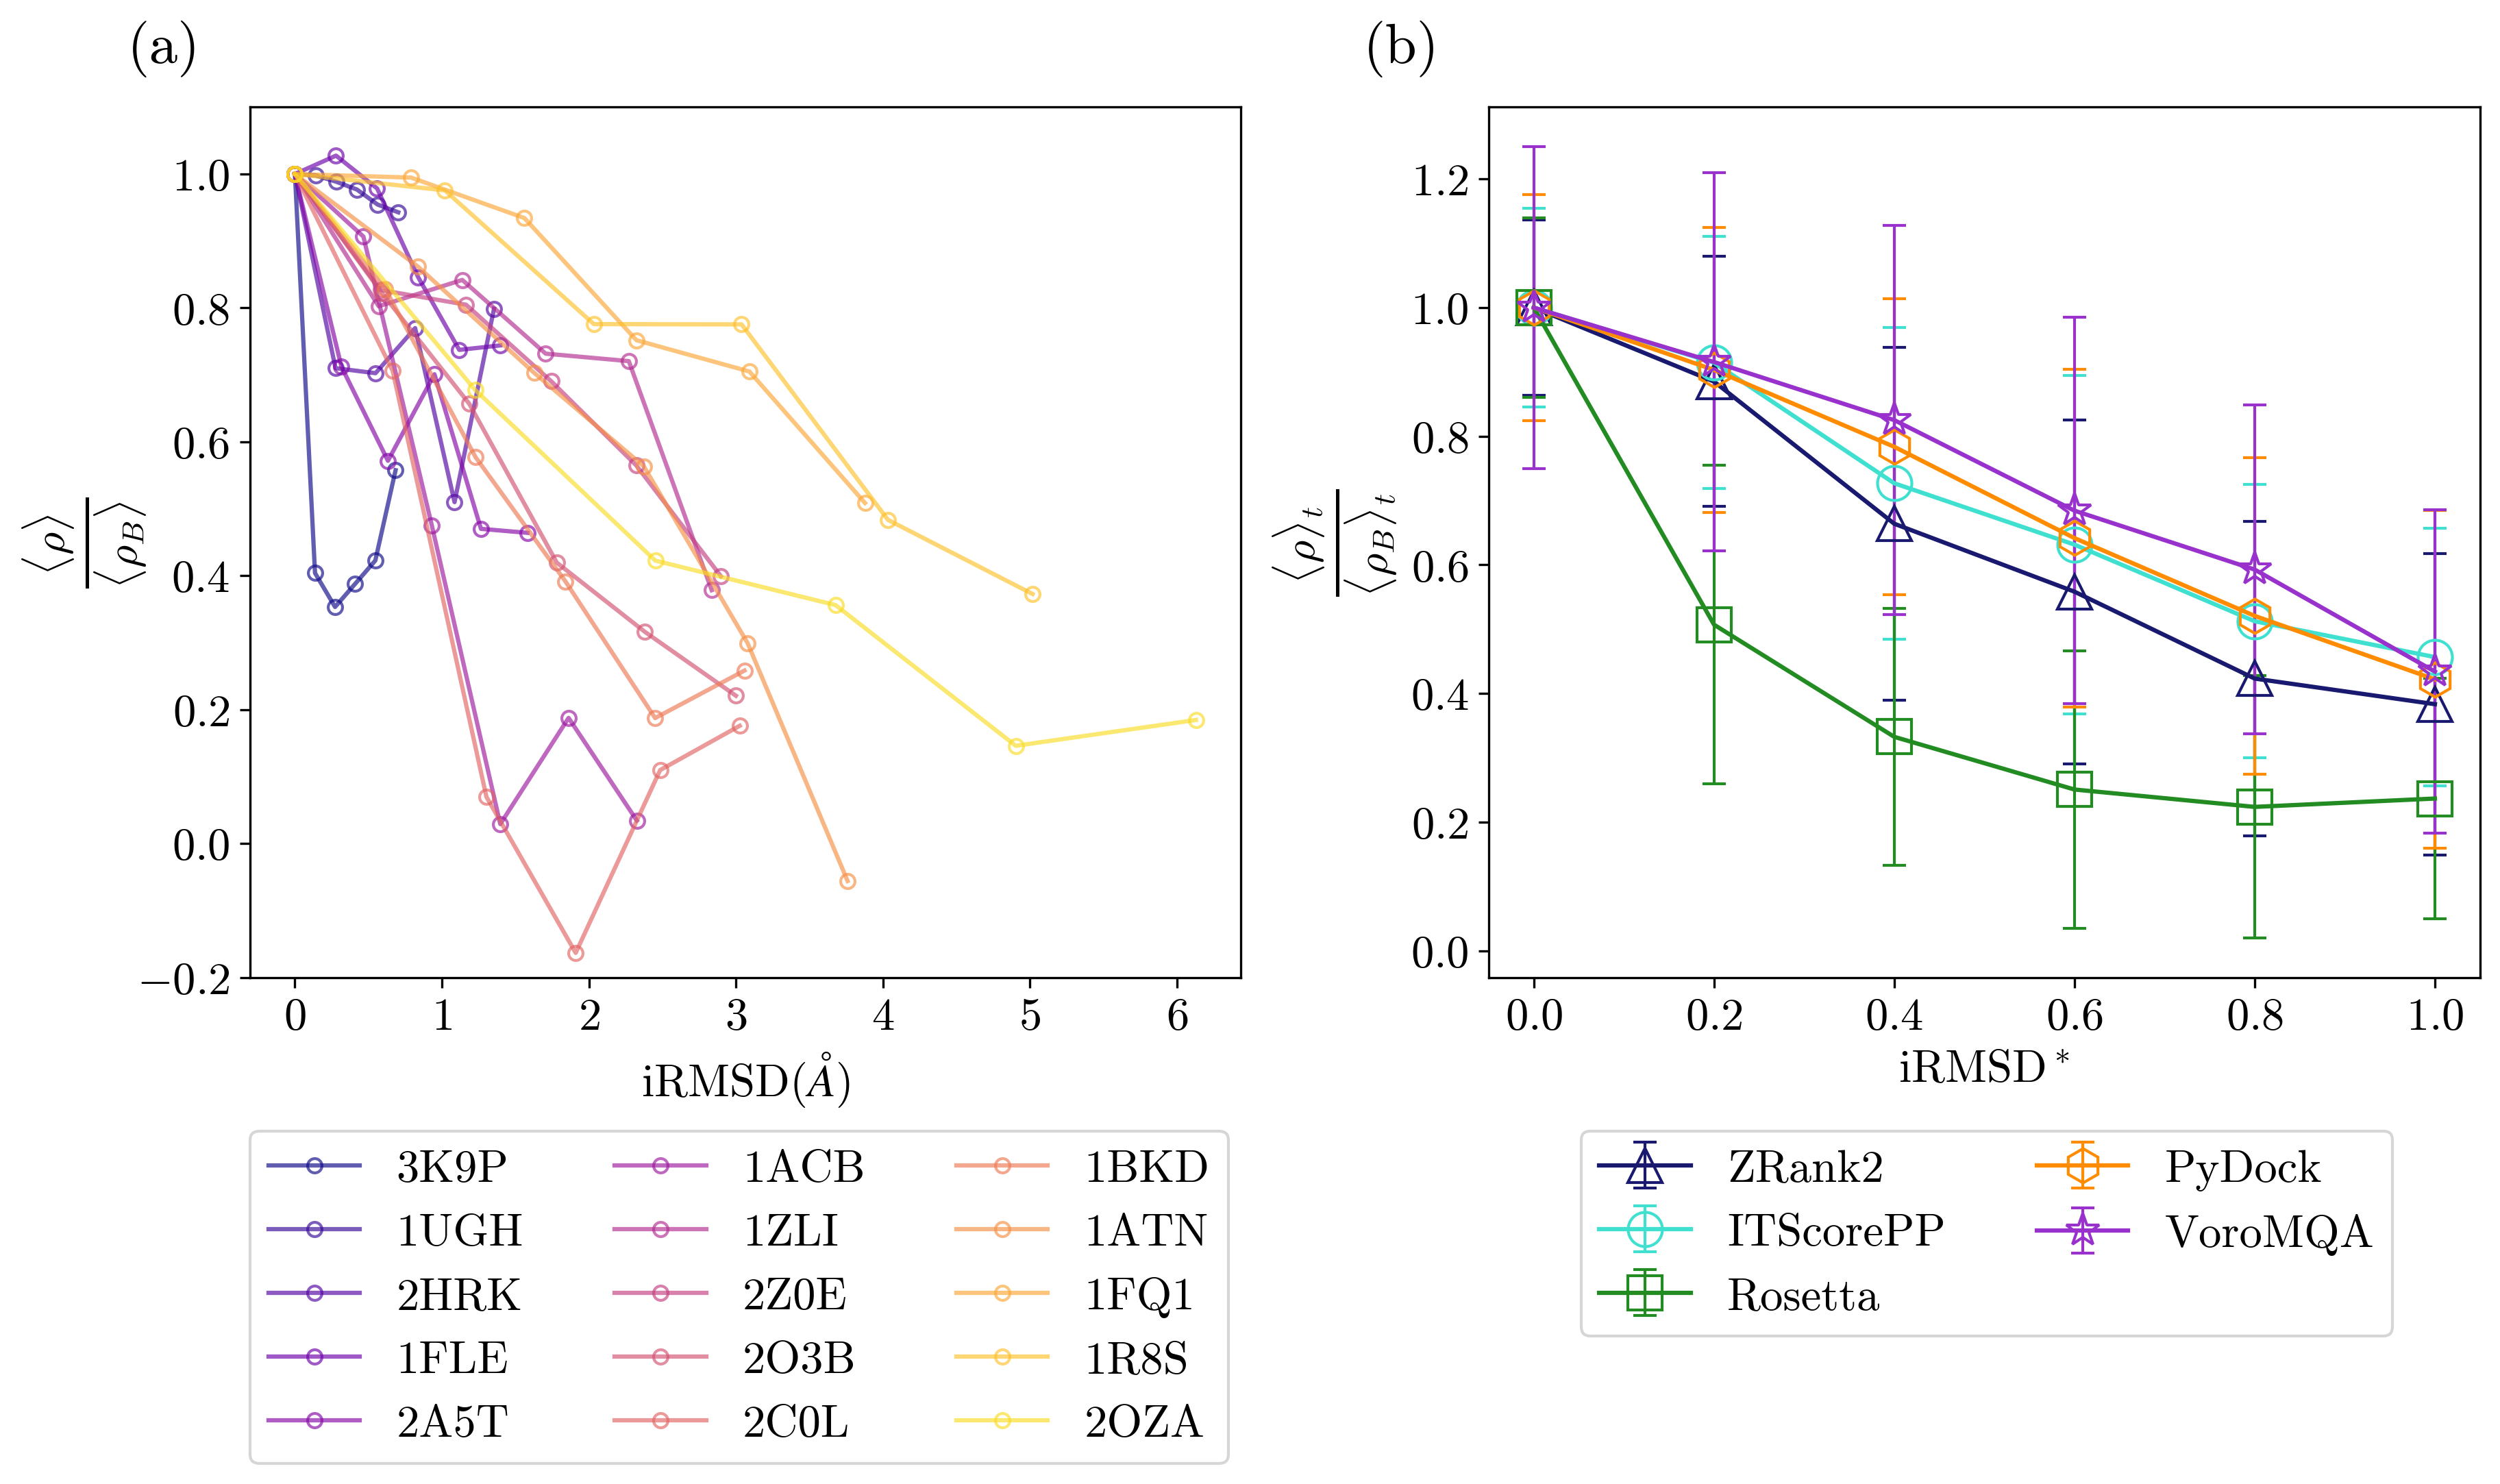

In [17]:
## Create fig. 8

final_rmsd=[]

for targ in finished_targs:
    final_rmsd.append([targ,rmsd_dict[f'{targ}_1000'][5]])
    
final_irmsd_df=pd.DataFrame(final_rmsd).sort_values(1)

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, len(finished_targs)+1))

font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }
matplotlib.rc('font', **font)
rc('mathtext', fontset='cm')
font_size = 16

fig,(ax2,ax1)=plt.subplots(1,2,figsize=[14,5.5])

score_list=['ZRank2','ITScorePP','Rosetta','PyDock','VoroMQA']
score_colors=["midnightblue", "turquoise", "forestgreen", "darkorange", "darkorchid", "tomato"]
score_shapes=['^','o','s','h','*','d']
imgs=[0,.2,.4,.6,.8,1]

for i,score in enumerate(score_list):
    ax1.errorbar([0,.2,.4,.6,.8,1],
                 score_rho_avg_df[score].values/score_rho_avg_df.loc[0,score],
                 yerr=score_rho_std_df[score].values,
                 color=score_colors[i],marker=score_shapes[i],
                 markerfacecolor='None',label=score_list[i], 
                 markersize=12,
                 elinewidth=1,
                 linewidth=1.5,
                 capsize=4,
                 alpha=1)


targ_avg_rho_df=pd.DataFrame(columns=runs,index=final_irmsd_df[0])

for ind,targ in enumerate(final_irmsd_df[0]):
    targ_rmsd=[0]

    ss_rosetta_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['Rosetta'])[0]
    try:
        ss_itscorepp_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['itscorepp'],nan_policy='omit')[0]
    except:
        ss_itscorepp_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['HDOCK'],nan_policy='omit')[0]
    ss_zrank_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['ZRank'])[0]
    ss_pydock_rho=spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['PyDock'])[0]
    ss_voromqa_rho=-spearmanr(ss_dict[targ]['DockQ'],ss_dict[targ]['VoroMQA'])[0]
    ss_all_rho=[ss_zrank_rho,ss_rosetta_rho,ss_itscorepp_rho,ss_voromqa_rho,ss_pydock_rho]
    targ_reweight=np.mean(ss_all_rho)
    targ_rho_avg=[np.mean(ss_all_rho)/targ_reweight]

    targ_rho_std=[np.std(ss_all_rho)]
    
    
    
    for i in runs:
        targ_rmsd.append(rmsd_dict[f'{targ}_{i}'][5])
        targ_rho_avg.append(rho_avg_dict[f'{targ}_{i}'][0]/targ_reweight)
        targ_rho_std.append(rho_avg_dict[f'{targ}_{i}'][1])
        targ_avg_rho_df.loc[targ,i]=rho_avg_dict[f'{targ}_{i}'][0]/targ_reweight
                            
    ax2.errorbar(targ_rmsd,targ_rho_avg,yerr=targ_rho_std,color=colors[ind],marker='o',markerfacecolor='None',label=targ, markersize=5,elinewidth=0,linewidth=1.5,alpha=.65)

ax1.set_xlabel(r'iRMSD$^*$',fontsize=font_size)
ax1.set_ylabel(r'$\frac{\langle\rho\rangle_t}{\langle\rho_B\rangle_t}$',fontsize=font_size+6)

ax2.set_xlabel(r'iRMSD$(\AA)$',fontsize=font_size)
ax2.set_ylabel(r'$\frac{\langle\rho\rangle}{\langle\rho_B\rangle}$',fontsize=font_size+6)
ax2.set_ylim(-.2,1.1)

    
ax1.text(
    -0.05, 1.1, "(b)",
    transform=ax1.transAxes,
    fontsize=int(font_size * 1.3),
    fontweight="bold",
    va="top", ha="right"
)
    
ax2.text(
    -0.05, 1.1, "(a)",
    transform=ax2.transAxes,
    fontsize=int(font_size * 1.3),
    fontweight="bold",
    va="top", ha="right"
)


ax1.tick_params(axis='both', which='major', labelsize=font_size)
ax2.tick_params(axis='both', which='major', labelsize=font_size)
ax2.yaxis.labelpad = -4

ax1.legend(fontsize=font_size,ncols=2,bbox_to_anchor=(.935, -.15))
ax2.legend(fontsize=font_size,bbox_to_anchor=(1.01, -.15),ncols=3)
plt.subplots_adjust(wspace=.25)
plt.show()

